In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


In [2]:
pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg

# University of California Admissions by Source School, 2016 to 2022
`universityofcalifornia.edu-admissions-1.1.2` Last Update: 2023-04-25T04:17:44

_These tables present information on UC’s Applicants, Admits, and Enrollees. Freshman applicant counts are presented for fall and transfer counts are presented for the full academic year.  Mean high school and transfer GPA are presented for freshman and transfer applicants, admits, and enrollees respectively by source school._


This data package presents data scraped from a Tableau vizualization on the
Univerity of California's data system, for the admissions to UC Campuses by the
source high school. The dataset provides the number of students that applied from each high school to each UC Campus, as well as the number admitted and enrolled. 


The UC data was collected by manually "scraping" the Tableau vizualiztion; each
combination of UC campus and year was selected and downloaded to a file, and
these files were combined into a single dataset. Then, the UC records were
matched to California Department of Education records using a fuzzy match on
the names. Only about 83% of the records could be relabily matched, with a
score of .8 or greater. See the ``matches`` file for all of the matches and
their scores.
## Documentation Links

* [Data Viz Page](https://www.universityofcalifornia.edu/about-us/information-center/admissions-source-school) THe web page that hosts the datavizualization

 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* **[uc_admissions](data/uc_admissions.csv)**. UC admissions data, by source school, for multiple years
* **[matches](data/matches.csv)**. Control file for the name matching between the UC data and CDE records.

## References
<ul><li> <strong>public_schools</string>, <em>metapack+http://library.metatab.org/cde.ca.gov-schools-2.1.1.csv</em>. California public schools</li><ul>

In [3]:
uca = pkg.resource('uc_admissions').dataframe()
uca.head()

,year,cdscode,ncesdist,ncesschool,school,uc_school,campus,uc_city,cde_city,county,...,region_y,charter,virtual,magnet,eilname,gsserved,zip,latitude,longitude,score
0,2022,36677103630555,0613920,10301,Fontana A. B. Miller High,A B MILLER HIGH SCHOOL,Santa Cruz,Fontana,Fontana,San Bernardino,...,san bernardino,N,N,N,High School,9-12,92336-1400,34.130144,-117.44883,80.0
1,2022,36677103630555,0613920,10301,Fontana A. B. Miller High,A B MILLER HIGH SCHOOL,Santa Cruz,Fontana,Fontana,San Bernardino,...,san bernardino,N,N,N,High School,9-12,92336-1400,34.130144,-117.44883,80.0
2,2022,36677103630555,0613920,10301,Fontana A. B. Miller High,A B MILLER HIGH SCHOOL,Santa Cruz,Fontana,Fontana,San Bernardino,...,san bernardino,N,N,N,High School,9-12,92336-1400,34.130144,-117.44883,80.0
3,2021,36677103630555,0613920,10301,Fontana A. B. Miller High,A B MILLER HIGH SCHOOL,Los Angeles,Fontana,Fontana,San Bernardino,...,san bernardino,N,N,N,High School,9-12,92336-1400,34.130144,-117.44883,80.0
4,2021,36677103630555,0613920,10301,Fontana A. B. Miller High,A B MILLER HIGH SCHOOL,Los Angeles,Fontana,Fontana,San Bernardino,...,san bernardino,N,N,N,High School,9-12,92336-1400,34.130144,-117.44883,80.0


In [4]:
uca.columns

Index(['year', 'cdscode', 'ncesdist', 'ncesschool', 'school', 'uc_school',
       'campus', 'uc_city', 'cde_city', 'county', 'county.1', 'district',
       'count', 'all', 'black', 'aian', 'hisp', 'nhpi', 'asian', 'white', 'na',
       'international', 'region_y', 'charter', 'virtual', 'magnet', 'eilname',
       'gsserved', 'zip', 'latitude', 'longitude', 'score'],
      dtype='object')

In [5]:
uca['count'].value_counts()

App    77604
Adm    77604
Enr    77604
Name: count, dtype: int64

In [7]:
# Calculate the acceptance rate for each hs/campus/year
ucar = uca[['cdscode','year', 'campus', 'count', 'black', 'hisp', 'asian', 'white']].set_index(['cdscode','year', 'campus'])

ucar_app = ucar[ucar['count'] == 'App'].iloc[:, 1:].astype(float)
ucar_enr = ucar[ucar['count'] == 'Enr'].iloc[:, 1:].astype(float)
ucar_adm = ucar[ucar['count'] == 'Adm'].iloc[:, 1:].astype(float)

acpt_rate = ucar_adm.div(ucar_app, axis=1).reset_index()
yield_rate = ucar_adm.div(ucar_adm, axis=1)

In [33]:
acpt_rate = acpt_rate.rename(columns={'hisp':'hisp_acpt', 'asian':'asian_acpt', 'white':'white_acpt','black':'black_acpt'})

# Load Attendance by Race & Ethnicity Data

In [8]:
pkg = mp.open_package('http://library.metatab.org/cde.ca.gov-enrollment-1.2.2.csv')

# Create Dataframes
enrollment_df = pkg.resource('enrollment').dataframe()
race_eth_df = pkg.resource('race_eth').dataframe()

In [9]:
# Change the columns to not conflict with the UC data. 'ada' == 'average daily attendence
cols = [ 'aian', 'asian', 'pi', 'filipino', 'hisp', 'black', 'nh_white', 'unk', 'two_more', 'total']
race_eth_df = race_eth_df.rename(columns={ e:e+'_ada' for e in cols })

In [10]:
# Change the columns to not conflict with the UC data. 'ada' == 'average daily attendence
cols = [ 'aian', 'asian', 'pi', 'filipino', 'hisp', 'black', 'nh_white', 'unk', 'two_more', 'total']
race_eth_df = race_eth_df.rename(columns={ e:e+'_ada' for e in cols })

In [11]:
# Convert counts to percentages
re = race_eth_df.loc[:,'aian_ada':'two_more_ada'].div(race_eth_df.total_ada, axis=0)
re = re.rename(columns={ c: c.replace('_ada','_pct') for c in re.columns}).astype(float)

# Re-attach cdscode and year
re = race_eth_df[['cdscode','year']].join(re)
re.head()

,cdscode,year,aian_pct,asian_pct,pi_pct,filipino_pct,hisp_pct,black_pct,nh_white_pct,unk_pct,two_more_pct
0,1100170109835,2007,0.013219,0.299378,0.022551,0.016330,0.076983,0.090980,0.304821,0.175739,0.000000
1,1100170109835,2008,0.003577,0.306867,0.013591,0.006438,0.053648,0.089413,0.283977,0.242489,0.000000
2,1100170109835,2009,0.004170,0.195969,0.020153,0.017373,0.124392,0.101459,0.507992,0.000000,0.000000
3,1100170109835,2010,0.007432,0.195946,0.020270,0.014189,0.122973,0.106081,0.508784,0.000000,0.000000
4,1100170109835,2011,0.007533,0.198368,0.020088,0.020716,0.120527,0.092906,0.517891,0.000000,0.001883


In [12]:
# Subset the race/ethnicity


re_ss = re[['cdscode','year','asian_pct','hisp_pct','nh_white_pct','black_pct']].copy()

# classify the school by the dominant race/eth
def classify_dom(r):
    return r.sort_values(ascending=False).index[0]


re_ss['dominant'] = re_ss.loc[:, 'asian_pct':].apply(classify_dom, axis=1 )

# Rename the values to match the score columns
re_ss['dominant'] = re_ss['dominant'].replace({ e:e.replace('_pct','_score') for e in re_ss['dominant'].unique()})

In [13]:
re_ss['dominant'] = re_ss['dominant'].replace({'nh_white_score':'nhwhite_score'})

In [14]:
re_ss.dominant.value_counts()/len(re_ss)

hisp_score       0.605517
nhwhite_score    0.321637
asian_score      0.050273
black_score      0.022573
Name: dominant, dtype: float64

# Load CAASPP test scores

In [15]:

pkg = mp.open_package('http://library.metatab.org/cde.ca.gov-caaspp-2015e-2.1.1.csv')

# Create Dataframes
subgroup_ids_df = pkg.resource('subgroup_ids').dataframe()
test_ids_df = pkg.resource('test_ids').dataframe()
sg = pkg.resource('subgroups').dataframe()
entities_df = pkg.resource('entities').dataframe()

In [16]:
# Generate CDS codes. 
county_codes = sg.county_code.astype('str').str.zfill(2)
district_code = sg.district_code.astype('str').str.zfill(5)
school_code = sg.school_code.astype('str').str.zfill(14-2-5) # CDS codes are 14 digits
cds_code = (county_codes+district_code+school_code).astype(int)

In [17]:
sg['cds_code'] = cds_code
sg['mean_scale_score'] = pd.to_numeric(sg.mean_scale_score, errors='coerce')

In [18]:
#cols = [
#    'cds_code', 'year', 'subgroup_id', 'test_id', 'grade', 
#    'caaspp_reported_enrollment', 'students_tested', 'students_with_scores',
#    'total_caaspp_enrollment','total_tested_at_entity_level','total_tested_at_subgroup_level', 
#    'mean_scale_score', 'percentage_standard_met_and_above', 'percentage_standard_nearly_met',
#    'area_1_percentage_above_standard', 'area_2_percentage_above_standard', 
#    'area_3_percentage_above_standard', 'area_4_percentage_above_standard'
#]

cols = [ 'cds_code', 'year', 'subgroup_id', 'test_id', 'grade',  'mean_scale_score', 'percentage_standard_met_and_above'] 
 
subgroup_codes = {
74: 'black',    # 'Black or African American',
75: 'aian',     # 'American Indian or Alaska Native',
76: 'asian',    # 'Asian',
77: 'filipino', # 'Filipino',
78: 'hisp',     # 'Hispanic or Latino',
79: 'nhopi',    # 'Native Hawaiian or Pacific Islander',
80: 'nhwhite',  # 'White',
144: 'multi',   # 'Ethnicity -- Two or More Races'
}

t = sg[sg.subgroup_id.isin(list(subgroup_codes.keys())) ].copy()

# Not .replace b/c has some problem with datatype. IDK. 
t['subgroup_id'] =t.subgroup_id.apply(lambda v: subgroup_codes.get(v,v) ).astype('str')
t = t.rename(columns={'test_year':'year'})

t = t[t.school_code != 0] # exclude districts; keep just schools
test_scores = t[cols].copy()

In [19]:
t.sample(10).head()

,county_code,district_code,school_code,filler,year,subgroup_id,test_type,total_caaspp_enrollment,total_tested_at_entity_level,total_tested_at_subgroup_level,...,total_tested_with_scores,area_1_percentage_near_standard,area_2_percentage_near_standard,area_3_percentage_near_standard,area_4_percentage_near_standard,total_tested_at_reporting_level,total_tested_with_scores_at_reporting_level,students_enrolled,type_id,cds_code
11372452,33,67249,6115125,NaN,2018,black,B,<NA>,106,<NA>,...,106,25.58,27.91,46.51,51.16,NaN,NaN,NaN,NaN,33672496115125
6027433,49,70995,6110324,NaN,2016,multi,B,26,26,<NA>,...,26,55,36,45,64,NaN,NaN,NaN,NaN,49709956110324
14419088,30,66431,6058903,NaN,2021,hisp,B,<NA>,<NA>,<NA>,...,NaN,61.25,52.20,76.25,59.88,337,321,218,7.0,30664316058903
11355277,33,67215,6032536,NaN,2018,aian,B,<NA>,<NA>,<NA>,...,*,*,*,*,*,NaN,NaN,NaN,NaN,33672156032536
13925059,19,64733,6019632,NaN,2021,nhwhite,B,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,0,0,*,7.0,19647336019632


In [20]:
# Test id 1 = SB - English Language Arts/Literacy
# Test id 2 = SB - Mathematics

ts_ss = test_scores[(test_scores.test_id==2) & (test_scores.grade == 11) ] # "test score sub-set"

t = ts_ss.set_index(['cds_code', 'year', 'subgroup_id'])[['mean_scale_score']].unstack().droplevel(0, axis=1)

race_cols = ['nhwhite','asian','black','hisp']

ts = t[race_cols].reset_index().rename(columns={'cds_code':'cdscode'})

ts = ts.rename(columns={e:e+'_score' for e in race_cols} )

ts.head()

subgroup_id,cdscode,year,nhwhite_score,asian_score,black_score,hisp_score
0,1100170109835,2015,2470.8,NaN,NaN,NaN
1,1100170112607,2015,NaN,NaN,2465.8,2501.9
2,1100170112607,2016,NaN,NaN,2496.7,2503.8
3,1100170112607,2017,NaN,NaN,2519.9,2510.0
4,1100170112607,2018,NaN,NaN,2528.6,2542.0


In [26]:
# Merge test scores and race/ethnicity
tsre = ts.merge(re_ss, on=['cdscode','year'])
tsre['dominant_score'] = tsre.apply(lambda r: r[r.dominant], axis=1)
tsre

,cdscode,year,nhwhite_score,asian_score,black_score,hisp_score,asian_pct,hisp_pct,nh_white_pct,black_pct,dominant,dominant_score
0,1100170112607,2015,NaN,NaN,2465.8,2501.9,0.017199,0.513514,0.031941,0.383292,hisp_score,2501.9
1,1100170112607,2016,NaN,NaN,2496.7,2503.8,0.019851,0.526055,0.044665,0.372208,hisp_score,2503.8
2,1100170112607,2017,NaN,NaN,2519.9,2510.0,0.021792,0.556901,0.026634,0.334140,hisp_score,2510.0
3,1100170112607,2018,NaN,NaN,2528.6,2542.0,0.015584,0.563636,0.036364,0.327273,hisp_score,2542.0
4,1100170112607,2021,NaN,NaN,2529.9,2539.1,0.004866,0.445255,0.055961,0.389294,hisp_score,2539.1
...,...,...,...,...,...,...,...,...,...,...,...,...
12278,58727695838305,2015,2574.6,NaN,NaN,2540.2,0.021216,0.288543,0.519095,0.042433,nhwhite_score,2574.6
12279,58727695838305,2016,2542.5,NaN,NaN,2535.2,0.019074,0.301090,0.491826,0.034060,nhwhite_score,2542.5
12280,58727695838305,2017,2568.0,NaN,NaN,2565.3,0.020460,0.285166,0.479540,0.037084,nhwhite_score,2568.0
12281,58727695838305,2018,2579.4,NaN,NaN,2537.0,0.034527,0.281330,0.488491,0.030691,nhwhite_score,2579.4


In [22]:
tsre.groupby('dominant').dominant_score.mean()

dominant
asian_score      2711.410065
black_score      2461.486275
hisp_score       2500.066827
nhwhite_score    2575.541759
Name: dominant_score, dtype: float64

In [76]:
df = acpt_rate.merge(tsre, on =['cdscode','year'])
df['campus'] = df.campus.str.strip() # SHould fix this earlier
df['dominant'] = df.dominant.str.replace('_score','')

In [63]:
df.columns

Index(['cdscode', 'year', 'campus', 'black_acpt', 'hisp_acpt', 'asian_acpt',
       'white_acpt', 'nhwhite_score', 'asian_score', 'black_score',
       'hisp_score', 'asian_pct', 'hisp_pct', 'nh_white_pct', 'black_pct',
       'dominant', 'dominant_score'],
      dtype='object')

In [73]:
df.campus.value_counts().index

Index(['Universitywide', 'Davis', 'Los Angeles', 'Santa Barbara', 'Berkeley',
       'San Diego', 'Irvine', 'Santa Cruz', 'Riverside', 'Meced'],
      dtype='object')

In [61]:
df.groupby('year')[['nhwhite_score', 'asian_score', 'black_score','hisp_score']].mean()

,nhwhite_score,asian_score,black_score,hisp_score
year,,,,
2016,2604.354583,2666.093550,2530.710494,2551.508798
2017,2603.043582,2665.782861,2522.338993,2546.029290
2018,2603.316043,2664.617970,2520.665749,2543.453728
2021,2617.269072,2689.239932,2540.390166,2559.934230


In [77]:
df.groupby('dominant')[['nhwhite_score', 'asian_score', 'black_score','hisp_score']].mean()

,nhwhite_score,asian_score,black_score,hisp_score
dominant,,,,
asian,2648.613444,2713.680818,2551.121099,2580.761683
black,2557.468750,2595.427273,2465.932386,2498.840310
hisp,2589.192565,2643.214822,2517.139288,2537.416387
nhwhite,2623.536399,2703.502237,2557.665925,2574.504523


In [82]:
df[(df.campus=='San Diego') & (df.year==2018)].groupby('dominant')[['black_acpt', 'hisp_acpt', 'asian_acpt','white_acpt']].mean()

,black_acpt,hisp_acpt,asian_acpt,white_acpt
dominant,,,,
asian,0.277778,0.291784,0.284055,0.293620
black,NaN,NaN,0.236315,NaN
hisp,0.390103,0.295898,0.429661,0.423377
nhwhite,0.459753,0.322363,0.381681,0.334425


<AxesSubplot: xlabel='asian_score', ylabel='asian_acpt'>

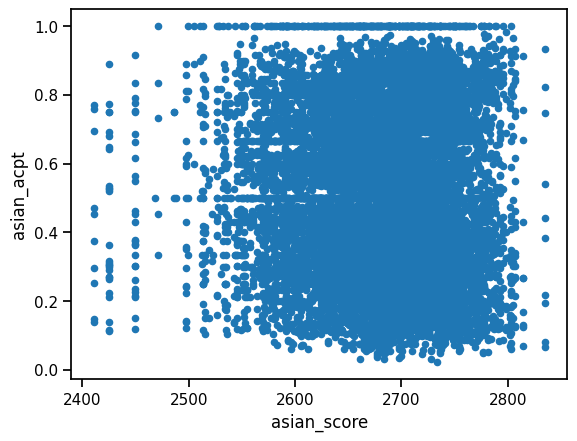

In [43]:
df[['asian_score','asian_acpt']].dropna().plot.scatter('asian_score','asian_acpt')

In [60]:
df[df.year==2021][['asian_score','asian_acpt']].dropna()

,asian_score,asian_acpt
286,2689.3,0.125000
287,2689.3,0.073826
289,2689.3,0.555556
290,2689.3,0.607595
292,2689.3,0.515625
...,...,...
35202,2724.6,0.833333
35203,2724.6,0.818182
35206,2724.6,0.894737
35986,2510.4,1.000000


In [44]:
df.groupby('dominant').dominant_score.mean()

dominant
asian_score      2713.680818
black_score      2465.932386
hisp_score       2537.416387
nhwhite_score    2623.536399
Name: dominant_score, dtype: float64

In [56]:
t = df.groupby(['campus'])[['black_acpt', 'hisp_acpt', 'asian_acpt','white_acpt']].mean()
(t.white_acpt - t.hisp_acpt).sort_values()

campus
 Berkeley           0.005122
 Los Angeles        0.037818
 San Diego          0.054599
 Santa Barbara      0.059540
 Universitywide     0.070424
 Davis              0.077210
 Irvine             0.098421
 Meced              0.117444
 Santa Cruz         0.137998
 Riverside          0.202655
dtype: float64

In [53]:
df.groupby(['campus'])[['black_acpt', 'hisp_acpt', 'asian_acpt','white_acpt']].mean().sort_values('asian_acpt')

,black_acpt,hisp_acpt,asian_acpt,white_acpt
campus,,,,
Los Angeles,0.307348,0.157039,0.198256,0.194857
Berkeley,0.342461,0.244396,0.259174,0.249518
Santa Barbara,0.416160,0.330816,0.410504,0.390357
Irvine,0.411828,0.299704,0.417260,0.398125
San Diego,0.386499,0.313261,0.424588,0.367861
Davis,0.404036,0.378985,0.447219,0.456195
Santa Cruz,0.557464,0.489975,0.623505,0.627972
Universitywide,0.562818,0.588399,0.720531,0.658823
Riverside,0.548253,0.536758,0.737103,0.739413
